<a href="https://colab.research.google.com/github/jasonli999/Alzheimer-s_CNN/blob/main/Alzheimers_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit to sentdex and his Youtube PyTorch tutorials for the basic CNN Model that we adapted. All adapted sections are marked below.


Import Statements are below:

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

In [14]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import os 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import time
import csv

Checks to see if a GPU is available for the model to run on:

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

print(f'Device is: {device}')

Device is: cuda:0


Downloads and unzips the Kaggle dataset into the local directory:

In [5]:
%%capture
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
!unzip "/content/augmented-alzheimer-mri-dataset.zip"
#downloads and unzips the dataset from Kaggle. Note that the kaggle.json API Token will need to be uploaded to the Colab for this to work

folder_to_array() adapted from Sentdex. Functions to pre-process the data. folder_to_array() is mainly used in the model to turn the images into numpy arrays and to classify the images.

In [6]:

def folder_to_csv(folder, classification, save = False):
    """Folder is a folder path, classification is the string classifiction. Save is a boolean
    folder_to_csv() returns a csv with the path of the images in the first column and the classification in the second column
    setting 'save' to true saves the csv to your drive with the name of the file as the name of the classification variable"""
    file_names = []
    for picture in os.listdir(folder):
      path = os.path.join(folder, picture)
      file_names.append([path, classification])
      df = pd.DataFrame(file_names, columns = ["File Path", "Classification"])
    if save == True:
        name = f'{classification}.csv'
        csv = df.to_csv(name, index = False)
    return df.to_csv(index = False)

def folder_to_array(folder, vectorlocation, image_size, save = False):
    """folder is a folder path, image_size is the image size of the post-processed picture, vectorlocation is the index of the one-hot vector
    folder_to_array() returns all of the images in the folder specified into an 2d array with column1 as the image array and column2 as the
    one-hot vector representing the data classification"""
    training_data = []
    for picture in tqdm(os.listdir(folder)):
        if "jpg" in picture:
            path = os.path.join(folder, picture)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (image_size, image_size))
            training_data.append([np.array(img), np.eye(4)[vectorlocation]]) #<- second index is the one-hot vector
    training_data = np.array(training_data, list)
    if save == True:
        np.save(folder, training_data)
    return training_data

Calls the folder_to_array() functions and creates the training and testing data arrays.

In [7]:
nondemented_array = folder_to_array("/content/AugmentedAlzheimerDataset/NonDemented", 0, 100)
verymilddemented_array = folder_to_array("/content/AugmentedAlzheimerDataset/VeryMildDemented", 1, 100)
milddemented_array = folder_to_array("/content/AugmentedAlzheimerDataset/MildDemented", 2, 100)
moderatedemented_array = folder_to_array("/content/AugmentedAlzheimerDataset/ModerateDemented", 3, 100)
#creates the arrays from the unzipped Kaggle data located in the Colab

train_size = int(min(len(nondemented_array), len(verymilddemented_array), len(milddemented_array), len(moderatedemented_array)))
#the size of each sample size in the training batch is half of the minimum sample size

train_size = int(train_size * 0.2) #try about ~20% of data in training instead

training_data = np.concatenate((nondemented_array[0: train_size], verymilddemented_array[0: train_size], milddemented_array[0: train_size], moderatedemented_array[0: train_size]))
testing_data = np.concatenate((nondemented_array[train_size:], verymilddemented_array[train_size:], milddemented_array[train_size:], moderatedemented_array[train_size:]))
#creates the training data by concatenating all of the arrays of length train_size together, creates testing data by concatenating the rest of the data
#generally we want a smaller portion of the data to be a part of the training dataset to avoid overfitting
np.random.shuffle(training_data)
np.random.shuffle(testing_data)
#Shuffling and randomizing the data

training_data = np.array(training_data)
testing_data = np.array(testing_data)


100%|██████████| 6464/6464 [00:03<00:00, 1659.48it/s]


Adapted from Sentdex. The framework for the CNN, which consists of Convolutional layers for processing the image, Max pooling layers which downscales the 2D convolutional data into 1D, and the Fully connected layers, which are the neural network.

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #optimize number of layers, hypertune parameters
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.pool2 = nn.MaxPool2d((2, 2))
        self.pool3 = nn.MaxPool2d((2, 2))
        self.fc1 = nn.Linear(10368, 10368) #size fo the fully connected layer was determined by the size of the pictures, which are 100 x 100 pixels
        self.fc2 = nn.Linear(10368, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.flatten(start_dim=1) # flattening out
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
  
#net.forward(torch.randn(1, 1, 100, 100))

Adapted from Sentdex. Transforms the numpy arrays into Pytorch tensors. 

In [9]:
training_picture = torch.Tensor([i[0] for i in training_data]).view(-1, 100, 100)
training_picture = training_picture/255.0
training_class = torch.Tensor([i[1] for i in training_data])

testing_picture = torch.Tensor([i[0] for i in testing_data]).view(-1, 100, 100)
testing_picture = testing_picture/255.0
testing_class = torch.Tensor([i[1] for i in testing_data])

#Warning: "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
#How to fix/make more efficent?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """Entry point for launching an IPython kernel.


Adapted from Sentdex. The training and testing function. fwd_pass is used to pass the training data through the CNN and adjust for loss. The fwd_test function finds a random set of data of size size to test the CNN on.

In [10]:
def fwd_pass(net, training_data, testing_data, loss_function, optimizer, train=False):
  #trains the function
  if train:
    net.zero_grad()
  outputs = net(training_data)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, testing_data)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, testing_data)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss

def fwd_test(net, loss_function, optimizer, size = 32):
  #size is the size of the random set of data that is used for the testing function
  random_start = np.random.randint(len(testing_picture) - size)
  test_pic, test_class = testing_picture[random_start: random_start + size], testing_class[random_start: random_start + size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(net, test_pic.view(-1, 1, 100, 100).to(device), test_class.to(device), loss_function, optimizer)
  return val_acc, val_loss


Adapted from Sentdex. Train() trains the CNN with the passed arguments and writes on a log file with all of the testing data. create_acc_loss_graph() creates a graph of the training data accuracy vs. the testing accuracy and the training loss vs. the testing loss.

In [43]:
def train(MODEL_NAME = f"model-{int(time.time())}", BATCH_SIZE = 50, EPOCHS = 5, learning_rate = 0.00008):
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr = learning_rate) #optimize loss rate
  loss_function = nn.MSELoss()
  labelbool = os.path.exists("/content/model.csv")
  with open("model.csv", "a") as f:
    if labelbool == False: #checks to see if file exists and if not, append the labels to the top
      listlabels = ["Model Name", "Time", "Train Accuracy", "Train Loss", "Test Accuracy", "Test Loss"]
      writer_object = csv.writer(f)
      writer_object.writerow(listlabels) #appends labels to top of csv
    for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(training_picture), BATCH_SIZE)):
          batch_pic = training_picture[i: i + BATCH_SIZE].view(-1, 1, 100, 100)
          batch_class = training_class[i: i + BATCH_SIZE]
          batch_pic, batch_class = batch_pic.to(device), batch_class.to(device)

          acc, loss = fwd_pass(net, batch_pic, batch_class, loss_function, optimizer, True)
          if i % 5 == 0: #sample rate, how many iterations til the network is tested
            val_acc, val_loss = fwd_test(net, loss_function, optimizer, size = 100) #<- change size for different size of testing sample
            listvars = [MODEL_NAME, round(time.time(), 3), round(float(acc), 2), round(float(loss), 4), round(float(val_acc), 2), round(float(val_loss), 4)]
            writer_object = csv.writer(f)
            writer_object.writerow(listvars) #appends data to bottom of csv file
      f.close()
      print(f'Epoch {epoch + 1} of {EPOCHS}')
  
  return MODEL_NAME

matplotlib.style.use("ggplot")

def create_acc_loss_graph(model_name, graph = True):
  #contents = open("model.log", 'r').read().split('\n')
  try:
    df = pd.read_csv("/content/model.csv")
    df = df.loc[df["Model Name"] == model_name]
  except:
    raise Exception("Did not load model csv in yet")
  
  if graph:
    #fig, axs = plt.subplots(figsize=(12, 4))
    
    fig = plt.figure()
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex = ax1)

    df["Test Accuracy"].plot(ax = ax1)
    df["Train Accuracy"].plot(ax = ax1)
    df["Train Loss"].plot(ax = ax2)
    df["Test Loss"].plot(ax = ax2)
    
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Accuracy")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Loss")

    plt.show()
  
  if graph == False:
    return times, accuracy, val_accs, losses, val_losses




test_params() is used to test different parameters on its affect on accuracy for epochs, loss rate, and batch size. It outputs a graph of the testing variable vs. the accuracy. 

In [56]:
def test_params(BATCH_SIZE, EPOCHS, learning_rate, graph = True):
  if graph:
    fig = plt.figure()
    ax = plt.subplot2grid((2, 1), (0, 0))

  if type(EPOCHS) == list and type(learning_rate) == float and type(BATCH_SIZE) == int:
    list_epochs = []
    list_accuracy = []
    for epoch in EPOCHS:
      print(f'Testing Epoch: {epoch}')
      list_epochs.append(epoch)
      MODEL_NAME = f"model-{int(time.time())}"
      print(f'Model Name {MODEL_NAME}')
      train(MODEL_NAME, BATCH_SIZE, epoch, learning_rate)
      times, accuracy, val_accs, losses, val_losses = create_acc_loss_graph(MODEL_NAME, False)
      list_ind = len(times) - int(len(times) * .1)
      val_accuracy = val_accs[list_ind:]
      val_average = sum(val_accuracy)/len(val_accuracy)
      list_accuracy.append(val_average)
    if graph:
      ax.plot(list_epochs, list_accuracy)
      ax.set_xlabel("Epochs")
      ax.set_ylabel("Accuracy")
    return list_epochs, list_accuracy
  
  elif type(EPOCHS) == int and type(learning_rate) == list and type(BATCH_SIZE) == int:
    list_learning_rate = []
    list_accuracy = []
    for lr in learning_rate:
      print(f'Testing Loss Rate: {lr}')
      list_learning_rate.append(lr)
      MODEL_NAME = f"model-{int(time.time())}"
      print(f'Model Name {MODEL_NAME}')
      train(MODEL_NAME, BATCH_SIZE, EPOCHS, lr)
      times, accuracy, val_accs, losses, val_losses = create_acc_loss_graph(MODEL_NAME, False)
      list_ind = len(times) - int(len(times) * .1)
      val_accuracy = val_accs[list_ind:]
      val_average = sum(val_accuracy)/len(val_accuracy)
      list_accuracy.append(val_average)
    if graph:
      ax.plot(list_learning_rate, list_accuracy)
      ax.set_xlabel("Loss Rates")
      ax.set_ylabel("Accuracy")
    return list_learning_rate, list_accuracy
  
  elif type(EPOCHS) == int and type(learning_rate) == float and type(BATCH_SIZE) == list:
    list_batch_size = []
    list_accuracy = []
    for size in BATCH_SIZE:
      print(f'Testing Batch Size: {size}')
      list_batch_size.append(size)
      MODEL_NAME = f"model-{int(time.time())}"
      print(f'Model Name {MODEL_NAME}')
      train(MODEL_NAME, size, EPOCHS, learning_rate)
      times, accuracy, val_accs, losses, val_losses = create_acc_loss_graph(MODEL_NAME, False)
      list_ind = len(times) - int(len(times) * .1)
      val_accuracy = val_accs[list_ind:]
      val_average = sum(val_accuracy)/len(val_accuracy)
      list_accuracy.append(val_average)
    if graph:
      ax.plot(list_batch_size, list_accuracy)
      ax.set_xlabel("Batch Sizes")
      ax.set_ylabel("Accuracy")
    return list_batch_size, list_accuracy

  elif type(EPOCHS) == int and type(learning_rate) == float and type(BATCH_SIZE) == int:
    MODEL_NAME = f"model-{int(time.time())}"
    print(f'Model Name {MODEL_NAME}')
    train(MODEL_NAME, BATCH_SIZE, EPOCHS, learning_rate)
    times, accuracy, val_accs, losses, val_losses = create_acc_loss_graph(MODEL_NAME, False)
    list_ind = len(times) - int(len(times) * .1)
    val_accuracy = val_accs[list_ind:]
    val_average = sum(val_accuracy)/len(val_accuracy)
    return val_average
  
  else: 
    raise TypeError("Please Input the Correct Types")

In [ ]:
#optimal learning rate is approximately 0.00006 per current testing
epoch_list = [1, 3, 5, 10]
test_params(50, 30, 0.00006, False)

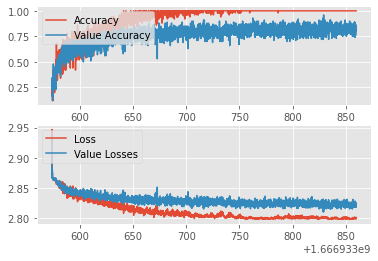

In [63]:
create_acc_loss_graph("model-1666933572", True)

-

-

-

-

-


Old Functions Below For Reference:

In [42]:
#Adapted from Sentdex

testing_picture.to(device)
testing_class.to(device)

def train(net, BATCH_SIZE = 100, EPOCHS = 10): #optimize parametes
  optimizer = optim.Adam(net.parameters(), lr = 0.00008) #optimize loss rate
  loss_function = nn.MSELoss()
  for epoch in range(EPOCHS):
      for i in tqdm(range(0, len(training_picture), BATCH_SIZE)):
          batch_pic = training_picture[i: i + BATCH_SIZE].view(-1, 1, 100, 100)
          batch_class = training_class[i: i + BATCH_SIZE]
          
          batch_pic, batch_class = batch_pic.to(device), batch_class.to(device) 
          
          net.zero_grad()
          outputs = net(batch_pic)
          loss = loss_function(outputs, batch_class)
          loss.backward()
          optimizer.step()
      print(f'Epoch: {epoch}, Loss: {loss}')

testing_picture = testing_picture[0:5000]
testing_class = testing_class[0:5000]

def test(net):
  correct, total = 0, 0
  with torch.no_grad():
      for i in tqdm(range(len(testing_picture))):
          real_class = torch.argmax(testing_class[i]).to(device)
          net_out = net(testing_picture[i].view(-1, 1, 100, 100).to(device))[0]
          predicted_class = torch.argmax(net_out)
          #print(f'{predicted_class}, {real_class}')
          if predicted_class == real_class:
              correct += 1
          total += 1
  print(correct, total)
  return(round(correct/total, 3))

In [ ]:
net = Net().to(device)
train(net, BATCH_SIZE = 100, EPOCHS = 5)
print(test(net))

In [ ]:
import matplotlib.pyplot as plt
loss_rate_test1 = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
loss_rate_test2 = [0.00008, 0.0001, 0.00015, 0.0002, 0.00025]
accuracy_list = []
for loss in loss_rate_test2:
  net1 = Net().to(device)
  train(net1, BATCH_SIZE = 100, EPOCHS = 3, loss_rate = loss)
  accuracy_list.append(test(net1))

plt.plot(loss_rate_test2, accuracy_list)
plt.ylabel("Accuracy")
plt.xlabel("Loss Rate")
plt.show()
